导入相关的库

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
import scipy.io as scio
import matlab.engine
import torch
from net import PhyCNN, PhyRNN
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
matlabeng = matlab.engine.start_matlab()   #启动matlab
from cvtKiKfile import getacc, getvel_dsp, baselineCorrection
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

声明台站、加载信息文件

In [2]:
station = 'IBRH13'
filedir = station + '_data'
filedir_Kal = station + '_data_Kalman'
msg = pd.read_excel(os.path.join(filedir, 'message.xlsx'))
msg = msg.sort_values('Record code')
msg['PGA-EW2 (g)'] *= 981
msg.rename(columns={'PGA-EW2 (g)': 'PGA (gal)'}, inplace=True)
event_list = np.loadtxt(os.path.join(station + '_results', 'selectevent.txt'), dtype=str)

提取FEM和反演FEM数据

In [ ]:
# dhacc_all = np.empty(shape=(0, 3000))
# upacc_all = np.empty(shape=(0, 3000))
# mdacc_all = np.empty(shape=(0, 3000))
# mdacc_Kal_all = np.empty(shape=(0, 3000))
# msg_all = np.empty(shape=(0, 4))
# event_list = np.loadtxt(os.path.join(station + '_results', 'selectevent.txt'), dtype=str)
# # idxfile = open(os.path.join(station + '_results', 'selectevent.txt'), 'w')
# # goodevents = np.loadtxt(os.path.join(station + '_results', 'goodevent.txt'), dtype=str)
# pbar = tqdm(enumerate(msg['Record code']), total=len(msg['Record code']), desc='计算中', ncols=100)
# for ind, name in pbar:
#     if msg.iloc[ind]['D95-EW1 (s)'] > 50 or msg.iloc[ind]['Record code'] not in event_list:
#         continue
#     else:
#         t5_dh, duration = msg.iloc[ind]['t5-EW1 (s)'], msg.iloc[ind]['D95-EW1 (s)']
#         # duration = t95_dh - t5_dh
#         t_start = max(t5_dh - (60 - duration) / 2, 0)
#         # t_start = max(t5_dh - 5, 0)
#         try:
#             acc = getacc(os.path.join(filedir, name, name + 'EW_dh_005.acc'))
#             dt = 0.005
#         except:
#             dt = 0.01
#         dhacc = getacc(os.path.join(filedir, name, 'dhfilterEW.acc'))
#         upacc = getacc(os.path.join(filedir, name, 'upfilterEW.acc'))
#         mdacc = getacc(os.path.join(filedir, name, 'surfaceEW.out')) / 9.81
#         mdacc_Kal = getacc(os.path.join(filedir_Kal, name, 'surfaceEW.out')) / 9.81
#         mdacc = mdacc - dhacc
#         mdacc_Kal = mdacc_Kal - dhacc
#         try:
#             dhacc_all = np.append(dhacc_all, dhacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
#             upacc_all = np.append(upacc_all, upacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
#             mdacc_all = np.append(mdacc_all, mdacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
#             mdacc_Kal_all = np.append(mdacc_Kal_all, mdacc_Kal[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
#             data = np.array(pd.DataFrame(msg, columns=['Depth (km)', 'Magnitude', 'Epicentral distance (km)', 'PGA (gal)'], index=[ind])).ravel()
#             msg_all = np.append(msg_all, data[None, :], axis=0)
#         except:
#             continue
# np.save(os.path.join(station + '_results', 'dhacc.npy'), dhacc_all)
# np.save(os.path.join(station + '_results', 'upacc.npy'), upacc_all)
# np.save(os.path.join(station + '_results', 'mdacc.npy'), mdacc_all)
# np.save(os.path.join(station + '_results', 'mdacc_Kal.npy'), mdacc_Kal_all)
# np.save(os.path.join(station + '_results', 'msg.npy'), msg_all)

加载FEM、反演FEM、CNN、LSTM数据

In [3]:
dhacc = np.load(os.path.join(station + '_results', 'dhacc.npy')) * 981
upacc = np.load(os.path.join(station + '_results', 'upacc.npy')) * 981
mdacc = np.load(os.path.join(station + '_results', 'mdacc.npy')) * 981
mdacc_Kal = np.load(os.path.join(station + '_results', 'mdacc_Kal.npy')) * 981
ttime = np.linspace(0.02, 0.02 * upacc.shape[1], upacc.shape[1])
Period = np.logspace(-2, 1, 101)


data_CNN = scio.loadmat(os.path.join(station + '_results', 'record_CNN', 'result.mat'))
data_LSTM = scio.loadmat(os.path.join(station + '_results', 'record_LSTM', 'result.mat'))

test_idx = data_CNN['test_idx'].ravel()
upacc_testset = upacc[test_idx]
mdacc_testset = mdacc[test_idx]
mdacc_Kal_testset = mdacc_Kal[test_idx]
CNNacc_testset = data_CNN['test_pred'][:, :, 0]
LSTMacc_testset = data_LSTM['test_pred'][:, :, 0]

train_idx = data_CNN['train_idx'].ravel()
upacc_trainset = upacc[train_idx]
mdacc_trainset = mdacc[train_idx]
mdacc_Kal_trainset = mdacc_Kal[train_idx]
CNNacc_trainset = data_CNN['train_pred'][:, :, 0]
LSTMacc_trainset = data_LSTM['train_pred'][:, :, 0]

dt = float(data_CNN['dt'])

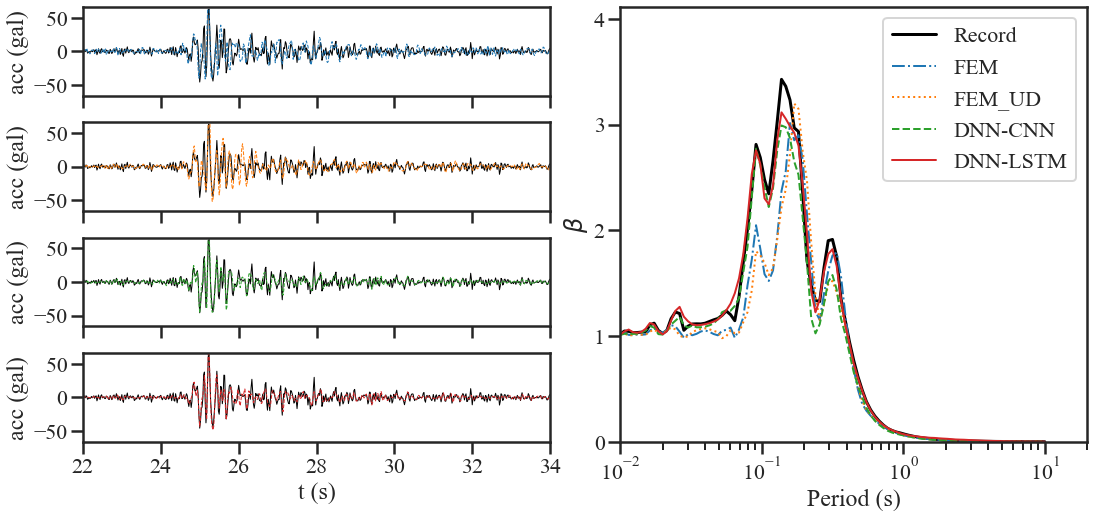

In [72]:
i=2
rps_up = matlabeng.getResponseSpectrum(matlab.double(upacc_testset[i, :].tolist()), dt)
rps_up = np.array(rps_up).ravel() / np.max(np.abs(upacc_testset[i, :]))
rps_md = matlabeng.getResponseSpectrum(matlab.double(mdacc_testset[i, :].tolist()), dt)
rps_md = np.array(rps_md).ravel() / np.max(np.abs(mdacc_testset[i, :]))
rps_md_Kal = matlabeng.getResponseSpectrum(matlab.double(mdacc_Kal_testset[i, :].tolist()), dt)
rps_md_Kal = np.array(rps_md_Kal).ravel() / np.max(np.abs(mdacc_Kal_testset[i, :]))
rps_CNN = matlabeng.getResponseSpectrum(matlab.double(CNNacc_testset[i, :].tolist()), dt)
rps_CNN = np.array(rps_CNN).ravel() / np.max(np.abs(CNNacc_testset[i, :]))
rps_LSTM = matlabeng.getResponseSpectrum(matlab.double(LSTMacc_testset[i, :].tolist()), dt)
rps_LSTM = np.array(rps_LSTM).ravel() / np.max(np.abs(LSTMacc_testset[i, :]))
PGA = np.max(np.abs(upacc_testset[i, :]))
Sam = np.max(rps_up)


plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.15)

ax1 = plt.subplot2grid((4, 2), (0, 0))
ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1)
ax1.plot(ttime, mdacc_testset[i, :], color=colors[0], linestyle='--', linewidth=1, label='FEM')
plt.xlim([22, 34])
ax1.set_xticklabels([])
plt.ylim([-1.05 * PGA, 1.05 * PGA])
plt.ylabel('acc (gal)')

ax1 = plt.subplot2grid((4, 2), (1, 0))
ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1)
ax1.plot(ttime, mdacc_Kal_testset[i, :], color=colors[1], linestyle='--', linewidth=1, label='FEM_UD')
plt.xlim([22, 34])
ax1.set_xticklabels([])
plt.ylim([-1.05 * PGA, 1.05 * PGA])
plt.ylabel('acc (gal)')


ax1 = plt.subplot2grid((4, 2), (2, 0))
ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1)
ax1.plot(ttime, CNNacc_testset[i, :], color=colors[2], linestyle='--', linewidth=1, label='DNN-CNN')
plt.xlim([22, 34])
ax1.set_xticklabels([])
plt.ylim([-1.05 * PGA, 1.05 * PGA])
plt.ylabel('acc (gal)')

ax1 = plt.subplot2grid((4, 2), (3, 0))
ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1)
ax1.plot(ttime, LSTMacc_testset[i, :], color=colors[3], linestyle='--', linewidth=1, label='DNN-LSTM')
plt.xlim([22, 34])
plt.ylim([-1.05 * PGA, 1.05 * PGA])
plt.xlabel('t (s)'), plt.ylabel('acc (gal)')


ax2 = plt.subplot2grid((4, 2), (0, 1), rowspan=4)
ax2.semilogx(Period, rps_up, color='k', linewidth=3, label='Record')
ax2.semilogx(Period, rps_md, color=colors[0], linestyle='-.', linewidth=2, label='FEM')
ax2.semilogx(Period, rps_md_Kal, color=colors[1], linestyle=':', linewidth=2, label='FEM_UD')
ax2.semilogx(Period, rps_CNN, color=colors[2], linestyle='--', linewidth=2, label='DNN-CNN')
ax2.semilogx(Period, rps_LSTM, color=colors[3], linestyle='-', linewidth=2, label='DNN-LSTM')
plt.xlim([0.01, 20])
plt.ylim([0, 1.2 * Sam])
plt.yticks(np.arange(0, 5, 1))
plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

plt.savefig(os.path.join(station + '_results', 'test%d_%s.svg' % (i, event_list[test_idx[i]])), bbox_inches='tight')

绘制每条地震动时程和反应谱对比图

In [45]:
dt = 0.02
pbar = tqdm(range(len(test_idx)), desc='Test', ncols=100)
for i in pbar:
    rps_up = matlabeng.getResponseSpectrum(matlab.double(upacc_testset[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel() / np.max(np.abs(upacc_testset[i, :]))
    rps_md = matlabeng.getResponseSpectrum(matlab.double(mdacc_testset[i, :].tolist()), dt)
    rps_md = np.array(rps_md).ravel() / np.max(np.abs(mdacc_testset[i, :]))
    rps_md_Kal = matlabeng.getResponseSpectrum(matlab.double(mdacc_Kal_testset[i, :].tolist()), dt)
    rps_md_Kal = np.array(rps_md_Kal).ravel() / np.max(np.abs(mdacc_Kal_testset[i, :]))
    rps_CNN = matlabeng.getResponseSpectrum(matlab.double(CNNacc_testset[i, :].tolist()), dt)
    rps_CNN = np.array(rps_CNN).ravel() / np.max(np.abs(CNNacc_testset[i, :]))
    rps_LSTM = matlabeng.getResponseSpectrum(matlab.double(LSTMacc_testset[i, :].tolist()), dt)
    rps_LSTM = np.array(rps_LSTM).ravel() / np.max(np.abs(LSTMacc_testset[i, :]))
    PGA = np.max(np.abs(upacc_testset[i, :]))
    Sam = np.max(rps_up)


    plt.figure(figsize=(18, 8))
    plt.subplots_adjust(hspace=0.3, wspace=0.15)

    ax1 = plt.subplot2grid((4, 2), (0, 0))
    ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, mdacc_testset[i, :], color=colors[0], linestyle='--', linewidth=1, label='FEM')
    # plt.xlim([15, 25])
    ax1.set_xticklabels([])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.ylabel('acc (gal)')

    ax1 = plt.subplot2grid((4, 2), (1, 0))
    ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, mdacc_Kal_testset[i, :], color=colors[1], linestyle='--', linewidth=1, label='FEM_UD')
    # plt.xlim([15, 25])
    ax1.set_xticklabels([])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.ylabel('acc (gal)')


    ax1 = plt.subplot2grid((4, 2), (2, 0))
    ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, CNNacc_testset[i, :], color=colors[2], linestyle='--', linewidth=1, label='DNN-CNN')
    # plt.xlim([15, 25])
    ax1.set_xticklabels([])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.ylabel('acc (gal)')

    ax1 = plt.subplot2grid((4, 2), (3, 0))
    ax1.plot(ttime, upacc_testset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, LSTMacc_testset[i, :], color=colors[3], linestyle='--', linewidth=1, label='DNN-LSTM')
    # plt.xlim([15, 25])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)')


    ax2 = plt.subplot2grid((4, 2), (0, 1), rowspan=4)
    ax2.semilogx(Period, rps_up, color='k', linewidth=3, label='Record')
    ax2.semilogx(Period, rps_md, color=colors[0], linestyle='--', linewidth=1, label='FEM')
    ax2.semilogx(Period, rps_md_Kal, color=colors[1], linestyle='--', linewidth=1, label='FEM_UD')
    ax2.semilogx(Period, rps_CNN, color=colors[2], linestyle='--', linewidth=1, label='DNN-CNN')
    ax2.semilogx(Period, rps_LSTM, color=colors[3], linestyle='--', linewidth=1, label='DNN-LSTM')
    plt.xlim([0.01, 20])
    plt.ylim([0, 1.2 * Sam])
    plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

    plt.savefig(os.path.join(station + '_results', 'comparison', 'test%d_%s.svg' % (i, event_list[test_idx[i]])), bbox_inches='tight')
    plt.close()

Test: 100%|███████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


计算MAE、MSE、SMAPE、r等指标参数

In [4]:
MAE_test = np.zeros((len(test_idx), 4))
RMSE_test = np.zeros((len(test_idx), 4))
SMAPE_test = np.zeros((len(test_idx), 4))
r_test = np.zeros((len(test_idx), 4))

MAE_test_rps = np.zeros((len(test_idx), 4))
RMSE_test_rps = np.zeros((len(test_idx), 4))
SMAPE_test_rps = np.zeros((len(test_idx), 4))
r_test_rps = np.zeros((len(test_idx), 4))

pbar = tqdm(range(len(test_idx)), desc='Calculating', ncols=100)
for i in pbar:
    rps_up = matlabeng.getResponseSpectrum(matlab.double(upacc_testset[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel() / np.max(np.abs(upacc_testset[i, :]))
    rps_md = matlabeng.getResponseSpectrum(matlab.double(mdacc_testset[i, :].tolist()), dt)
    rps_md = np.array(rps_md).ravel() / np.max(np.abs(mdacc_testset[i, :]))
    rps_md_Kal = matlabeng.getResponseSpectrum(matlab.double(mdacc_Kal_testset[i, :].tolist()), dt)
    rps_md_Kal = np.array(rps_md_Kal).ravel() / np.max(np.abs(mdacc_Kal_testset[i, :]))
    rps_CNN = matlabeng.getResponseSpectrum(matlab.double(CNNacc_testset[i, :].tolist()), dt)
    rps_CNN = np.array(rps_CNN).ravel() / np.max(np.abs(CNNacc_testset[i, :]))
    rps_LSTM = matlabeng.getResponseSpectrum(matlab.double(LSTMacc_testset[i, :].tolist()), dt)
    rps_LSTM = np.array(rps_LSTM).ravel() / np.max(np.abs(LSTMacc_testset[i, :]))
    PGA = np.max(np.abs(upacc_testset[i, :]))
    Sam = np.max(rps_up)
    
    MAE_test[i, 0] = np.mean(np.abs(mdacc_testset[i, :] - upacc_testset[i, :]) / PGA)
    MAE_test[i, 1] = np.mean(np.abs(mdacc_Kal_testset[i, :] - upacc_testset[i, :]) / PGA)
    MAE_test[i, 2] = np.mean(np.abs(CNNacc_testset[i, :] - upacc_testset[i, :]) / PGA)
    MAE_test[i, 3] = np.mean(np.abs(LSTMacc_testset[i, :] - upacc_testset[i, :]) / PGA)
    
    RMSE_test[i, 0] = np.sqrt(np.mean(((mdacc_testset[i, :] - upacc_testset[i, :]) / PGA)**2))
    RMSE_test[i, 1] = np.sqrt(np.mean(((mdacc_Kal_testset[i, :] - upacc_testset[i, :]) / PGA)**2))
    RMSE_test[i, 2] = np.sqrt(np.mean(((CNNacc_testset[i, :] - upacc_testset[i, :]) / PGA)**2))
    RMSE_test[i, 3] = np.sqrt(np.mean(((LSTMacc_testset[i, :] - upacc_testset[i, :]) / PGA)**2))
    
    r_test[i, 0] = np.corrcoef(mdacc_testset[i, :], upacc_testset[i, :])[0, 1]
    r_test[i, 1] = np.corrcoef(mdacc_Kal_testset[i, :], upacc_testset[i, :])[0, 1]
    r_test[i, 2] = np.corrcoef(CNNacc_testset[i, :], upacc_testset[i, :])[0, 1]
    r_test[i, 3] = np.corrcoef(LSTMacc_testset[i, :], upacc_testset[i, :])[0, 1]
    
    MAE_test_rps[i, 0] = np.mean(np.abs(rps_md - rps_up) / Sam)
    MAE_test_rps[i, 1] = np.mean(np.abs(rps_md_Kal - rps_up) / Sam)
    MAE_test_rps[i, 2] = np.mean(np.abs(rps_CNN - rps_up) / Sam)
    MAE_test_rps[i, 3] = np.mean(np.abs(rps_LSTM - rps_up) / Sam)
    
    RMSE_test_rps[i, 0] = np.sqrt(np.mean(((rps_md - rps_up) / Sam)**2))
    RMSE_test_rps[i, 1] = np.sqrt(np.mean(((rps_md_Kal - rps_up) / Sam)**2))
    RMSE_test_rps[i, 2] = np.sqrt(np.mean(((rps_CNN - rps_up) / Sam)**2))
    RMSE_test_rps[i, 3] = np.sqrt(np.mean(((rps_LSTM - rps_up) / Sam)**2))
    
    r_test_rps[i, 0] = np.corrcoef(rps_md, rps_up)[0, 1]
    r_test_rps[i, 1] = np.corrcoef(rps_md_Kal, rps_up)[0, 1]
    r_test_rps[i, 2] = np.corrcoef(rps_CNN, rps_up)[0, 1]
    r_test_rps[i, 3] = np.corrcoef(rps_LSTM, rps_up)[0, 1]

Calculating: 100%|████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


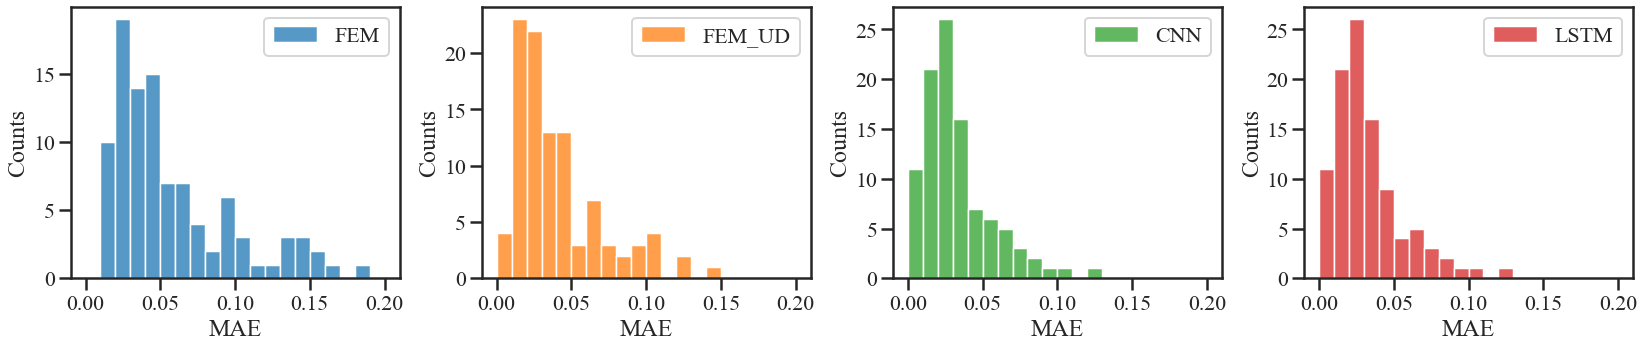

In [5]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(MAE_test[:, 0], bins=20, binrange=[0, 0.2], color=colors[0], label='FEM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(1, 4, 2)
sns.histplot(MAE_test[:, 1], bins=20, binrange=[0, 0.2], color=colors[1], label='FEM_UD')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(1, 4, 3)
sns.histplot(MAE_test[:, 2], bins=20, binrange=[0, 0.2], color=colors[2], label='DNN-CNN')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(1, 4, 4)
sns.histplot(MAE_test[:, 3], bins=20, binrange=[0, 0.2], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.savefig(os.path.join(station + '_results', 'test_MAE.svg'), bbox_inches='tight')

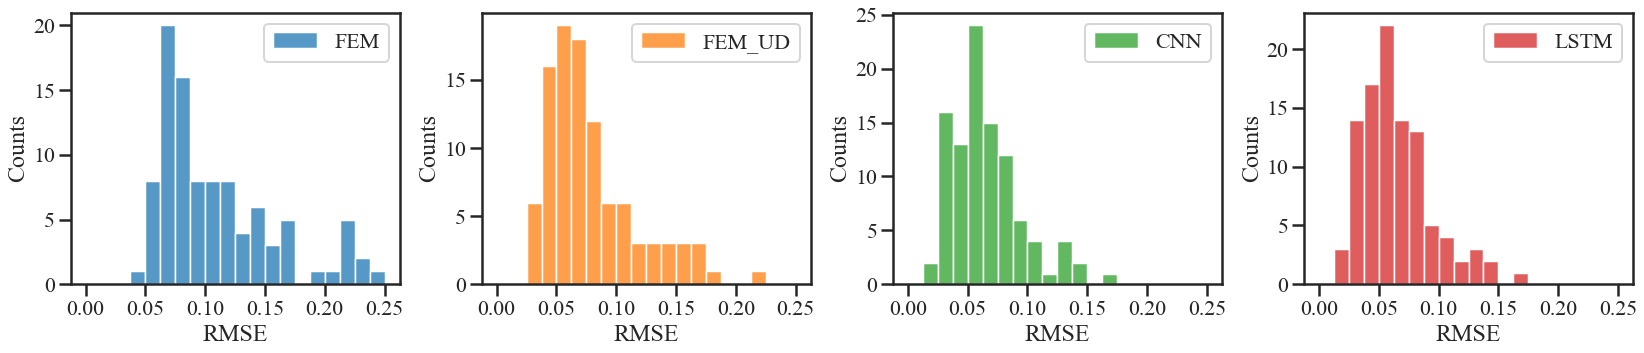

In [6]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(RMSE_test[:, 0], bins=20, binrange=[0, 0.25], color=colors[0], label='FEM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(1, 4, 2)
sns.histplot(RMSE_test[:, 1], bins=20, binrange=[0, 0.25], color=colors[1], label='FEM_UD')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(1, 4, 3)
sns.histplot(RMSE_test[:, 2], bins=20, binrange=[0, 0.25], color=colors[2], label='DNN-CNN')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(1, 4, 4)
sns.histplot(RMSE_test[:, 3], bins=20, binrange=[0, 0.25], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.3, 0.05))

plt.savefig(os.path.join(station + '_results', 'test_RMSE.svg'), bbox_inches='tight')

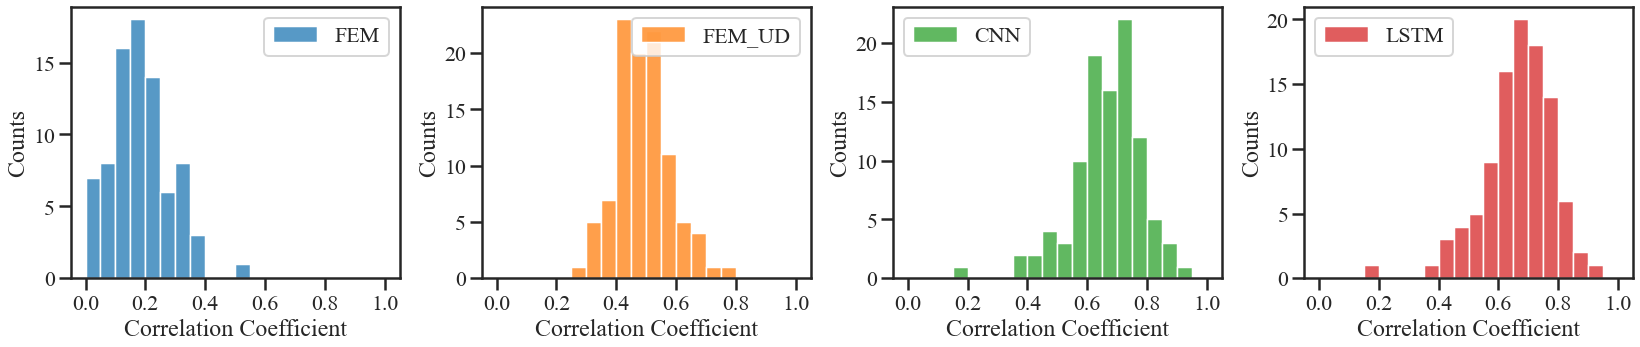

In [7]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(r_test[:, 0], bins=20, binrange=[0, 1], color=colors[0], label='FEM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(1, 4, 2)
sns.histplot(r_test[:, 1], bins=20, binrange=[0, 1], color=colors[1], label='FEM_UD')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(1, 4, 3)
sns.histplot(r_test[:, 2], bins=20, binrange=[0, 1], color=colors[2], label='DNN-CNN')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(1, 4, 4)
sns.histplot(r_test[:, 3], bins=20, binrange=[0, 1], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2))

plt.savefig(os.path.join(station + '_results', 'test_COrrcoef.svg'), bbox_inches='tight')

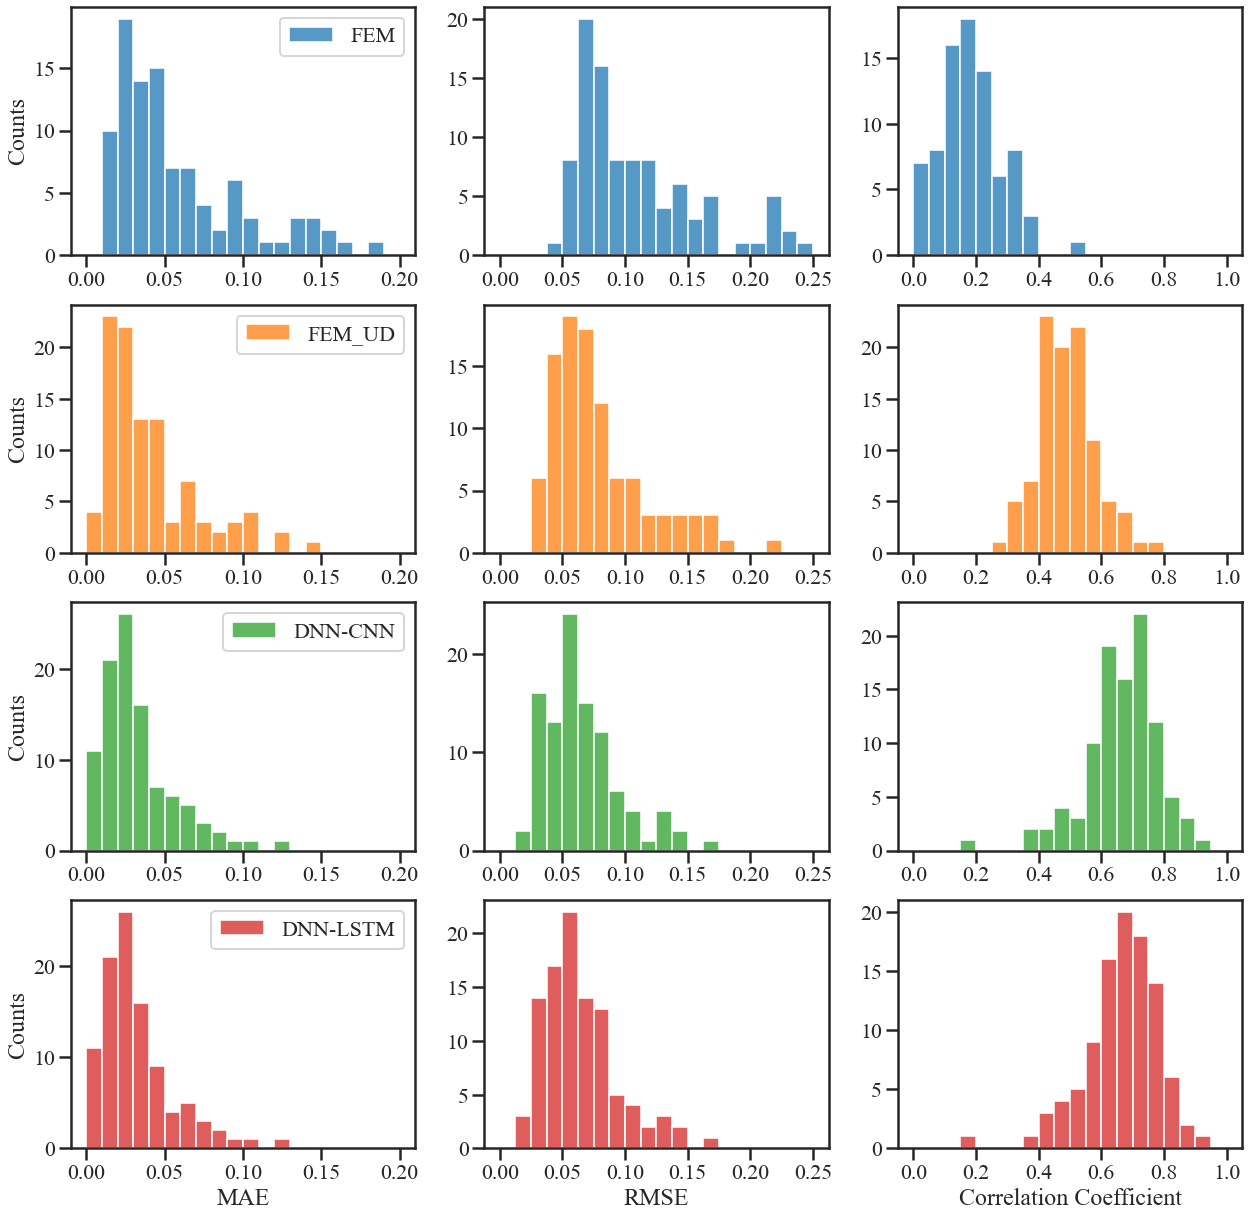

In [68]:
plt.figure(figsize=(21, 21))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(4, 3, 1)
sns.histplot(MAE_test[:, 0], bins=20, binrange=[0, 0.2], color=colors[0], label='FEM')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(4, 3, 4)
sns.histplot(MAE_test[:, 1], bins=20, binrange=[0, 0.2], color=colors[1], label='FEM_UD')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(4, 3, 7)
sns.histplot(MAE_test[:, 2], bins=20, binrange=[0, 0.2], color=colors[2], label='DNN-CNN')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))

plt.subplot(4, 3, 10)
sns.histplot(MAE_test[:, 3], bins=20, binrange=[0, 0.2], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.25, 0.05))


plt.subplot(4, 3, 2)
sns.histplot(RMSE_test[:, 0], bins=20, binrange=[0, 0.25], color=colors[0], label='FEM')
plt.ylabel('')
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(4, 3, 5)
sns.histplot(RMSE_test[:, 1], bins=20, binrange=[0, 0.25], color=colors[1], label='FEM_UD')
plt.ylabel('')
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(4, 3, 8)
sns.histplot(RMSE_test[:, 2], bins=20, binrange=[0, 0.25], color=colors[2], label='DNN-CNN')
plt.ylabel('')
plt.xticks(np.arange(0, 0.3, 0.05))

plt.subplot(4, 3, 11)
sns.histplot(RMSE_test[:, 3], bins=20, binrange=[0, 0.25], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('')
plt.xticks(np.arange(0, 0.3, 0.05))


plt.subplot(4, 3, 3)
sns.histplot(r_test[:, 0], bins=20, binrange=[0, 1], color=colors[0], label='FEM')
plt.ylabel('')
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(4, 3, 6)
sns.histplot(r_test[:, 1], bins=20, binrange=[0, 1], color=colors[1], label='FEM_UD')
plt.ylabel('')
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(4, 3, 9)
sns.histplot(r_test[:, 2], bins=20, binrange=[0, 1], color=colors[2], label='DNN-CNN')
plt.ylabel('')
plt.xticks(np.arange(0, 1.2, 0.2))

plt.subplot(4, 3, 12)
sns.histplot(r_test[:, 3], bins=20, binrange=[0, 1], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('')
plt.xticks(np.arange(0, 1.2, 0.2))

plt.savefig(os.path.join(station + '_results', 'test_all.svg'), bbox_inches='tight')

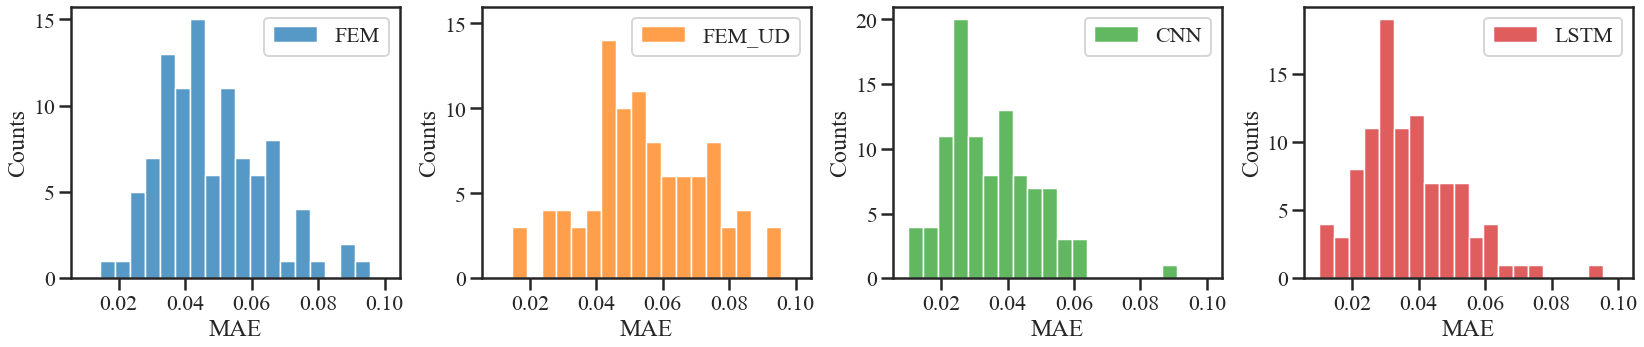

In [19]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(MAE_test_rps[:, 0], bins=20, binrange=[0.01, 0.1], color=colors[0], label='FEM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))

plt.subplot(1, 4, 2)
sns.histplot(MAE_test_rps[:, 1], bins=20, binrange=[0.01, 0.1], color=colors[1], label='FEM_UD')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02)), plt.yticks(np.arange(0, 16, 5)), plt.ylim([0, 16])

plt.subplot(1, 4, 3)
sns.histplot(MAE_test_rps[:, 2], bins=20, binrange=[0.01, 0.1], color=colors[2], label='DNN-CNN')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))

plt.subplot(1, 4, 4)
sns.histplot(MAE_test_rps[:, 3], bins=20, binrange=[0.01, 0.1], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))

plt.savefig(os.path.join(station + '_results', 'test_MAE_rps.svg'), bbox_inches='tight')

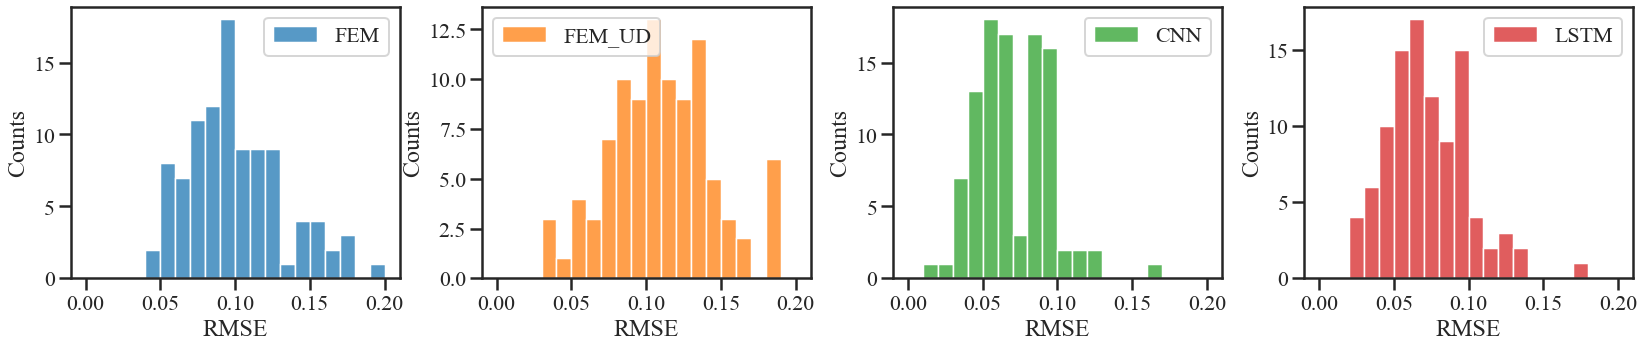

In [20]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(RMSE_test_rps[:, 0], bins=20, binrange=[0, 0.2], color=colors[0], label='FEM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))

plt.subplot(1, 4, 2)
sns.histplot(RMSE_test_rps[:, 1], bins=20, binrange=[0, 0.2], color=colors[1], label='FEM_UD')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))

plt.subplot(1, 4, 3)
sns.histplot(RMSE_test_rps[:, 2], bins=20, binrange=[0, 0.2], color=colors[2], label='DNN-CNN')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))

plt.subplot(1, 4, 4)
sns.histplot(RMSE_test_rps[:, 3], bins=20, binrange=[0, 0.2], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))

plt.savefig(os.path.join(station + '_results', 'test_RMSE_rps.svg'), bbox_inches='tight')

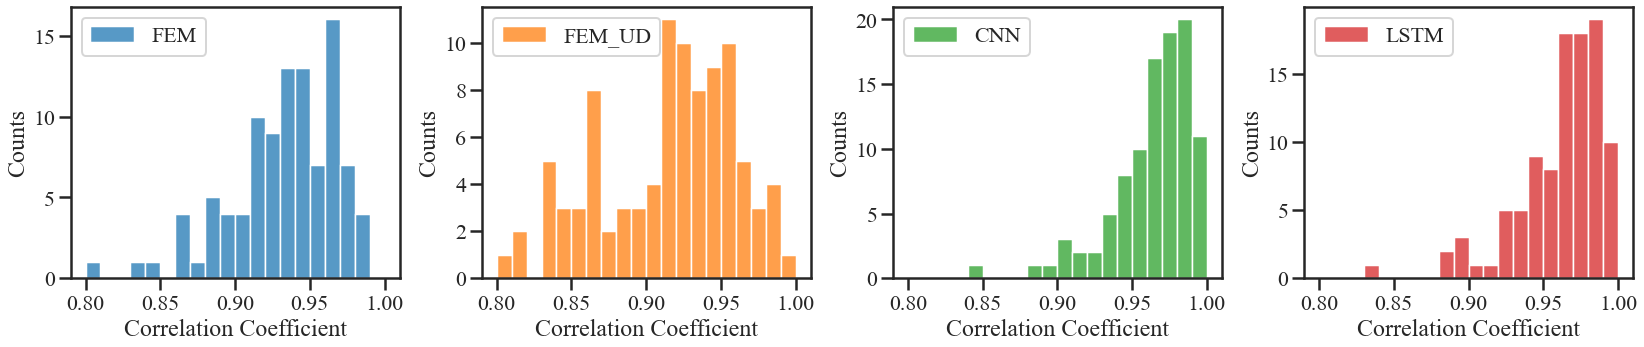

In [21]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 4, 1)
sns.histplot(r_test_rps[:, 0], bins=20, binrange=[0.8, 1], color=colors[0], label='FEM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.subplot(1, 4, 2)
sns.histplot(r_test_rps[:, 1], bins=20, binrange=[0.8, 1], color=colors[1], label='FEM_UD')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.subplot(1, 4, 3)
sns.histplot(r_test_rps[:, 2], bins=20, binrange=[0.8, 1], color=colors[2], label='DNN-CNN')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.subplot(1, 4, 4)
sns.histplot(r_test_rps[:, 3], bins=20, binrange=[0.8, 1], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.savefig(os.path.join(station + '_results', 'test_corrcoef_rps.svg'), bbox_inches='tight')

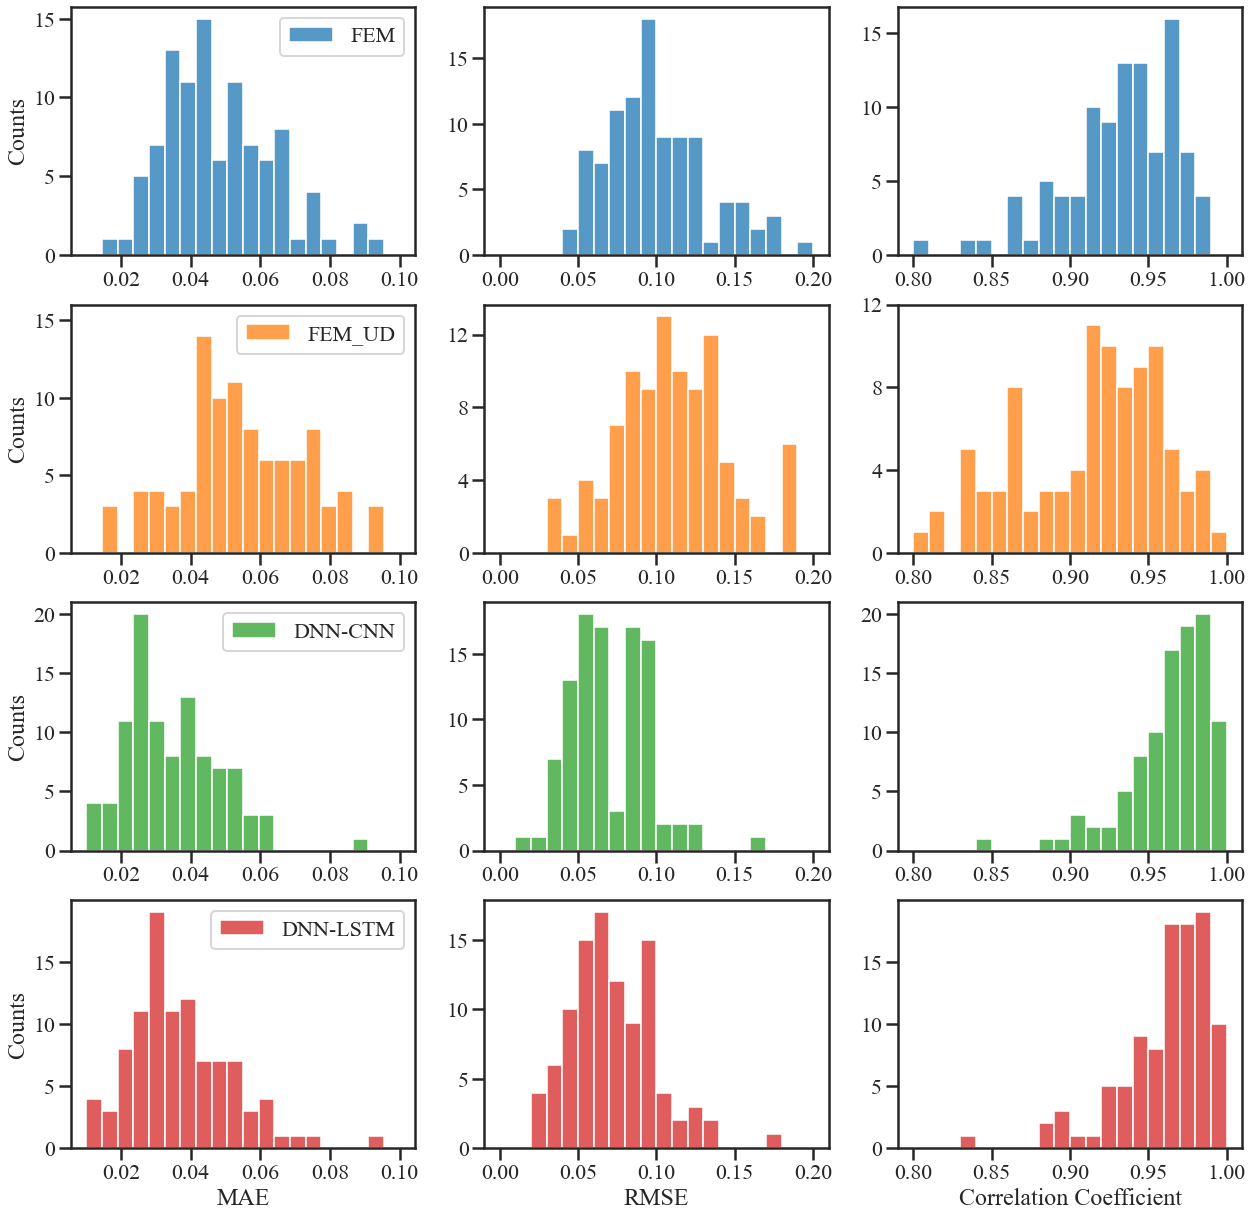

In [69]:
plt.figure(figsize=(21, 21))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(4, 3, 1)
sns.histplot(MAE_test_rps[:, 0], bins=20, binrange=[0.01, 0.1], color=colors[0], label='FEM')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))

plt.subplot(4, 3, 4)
sns.histplot(MAE_test_rps[:, 1], bins=20, binrange=[0.01, 0.1], color=colors[1], label='FEM_UD')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02)), plt.yticks(np.arange(0, 16, 5)), plt.ylim([0, 16])

plt.subplot(4, 3, 7)
sns.histplot(MAE_test_rps[:, 2], bins=20, binrange=[0.01, 0.1], color=colors[2], label='DNN-CNN')
plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))

plt.subplot(4, 3, 10)
sns.histplot(MAE_test_rps[:, 3], bins=20, binrange=[0.01, 0.1], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.02, 0.12, 0.02))


plt.subplot(4, 3, 2)
sns.histplot(RMSE_test_rps[:, 0], bins=20, binrange=[0, 0.2], color=colors[0], label='FEM')
plt.ylabel('')
plt.xticks(np.arange(0, 0.21, 0.05))

plt.subplot(4, 3, 5)
sns.histplot(RMSE_test_rps[:, 1], bins=20, binrange=[0, 0.2], color=colors[1], label='FEM_UD')
plt.ylabel('')
plt.xticks(np.arange(0, 0.21, 0.05)), plt.yticks(np.arange(0, 14, 4))

plt.subplot(4, 3, 8)
sns.histplot(RMSE_test_rps[:, 2], bins=20, binrange=[0, 0.2], color=colors[2], label='DNN-CNN')
plt.ylabel('')
plt.xticks(np.arange(0, 0.21, 0.05))

plt.subplot(4, 3, 11)
sns.histplot(RMSE_test_rps[:, 3], bins=20, binrange=[0, 0.2], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('')
plt.xticks(np.arange(0, 0.21, 0.05))


plt.subplot(4, 3, 3)
sns.histplot(r_test_rps[:, 0], bins=20, binrange=[0.8, 1], color=colors[0], label='FEM')
plt.ylabel('')
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.subplot(4, 3, 6)
sns.histplot(r_test_rps[:, 1], bins=20, binrange=[0.8, 1], color=colors[1], label='FEM_UD')
plt.ylabel('')
plt.xticks(np.arange(0.8, 1.01, 0.05)), plt.yticks(np.arange(0, 14, 4))

plt.subplot(4, 3, 9)
sns.histplot(r_test_rps[:, 2], bins=20, binrange=[0.8, 1], color=colors[2], label='DNN-CNN')
plt.ylabel('')
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.subplot(4, 3, 12)
sns.histplot(r_test_rps[:, 3], bins=20, binrange=[0.8, 1], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('')
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.savefig(os.path.join(station + '_results', 'test_all_rps.svg'), bbox_inches='tight')

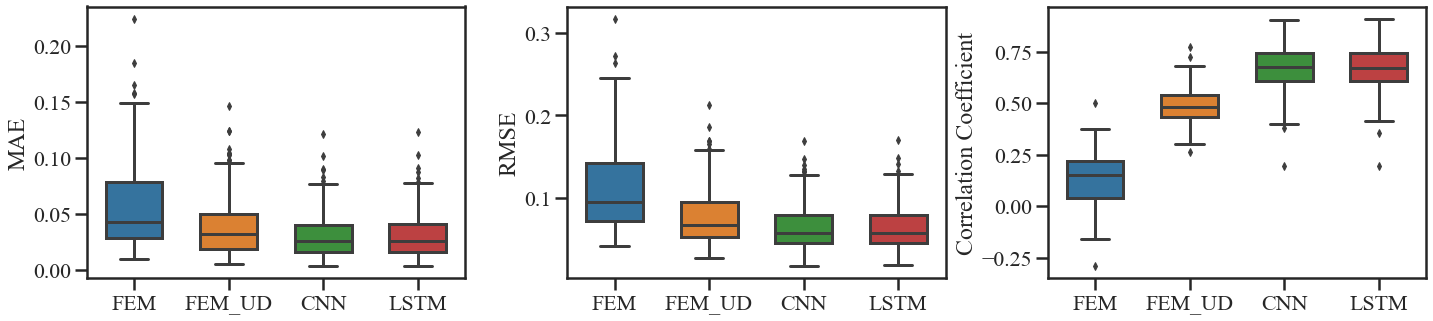

In [25]:
plt.figure(figsize=(24, 5))
plt.subplots_adjust(hspace=0, wspace=0.27)

plt.subplot(1, 3, 1)
ax = sns.boxplot(data=[d for d in MAE_test.T], saturation=0.7, width=0.6)
plt.ylabel('MAE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.subplot(1, 3, 2)
ax = sns.boxplot(data=[d for d in RMSE_test.T], saturation=0.7, width=0.6)
plt.ylabel('RMSE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.subplot(1, 3, 3)
ax = sns.boxplot(data=[d for d in r_test.T], saturation=0.7, width=0.6)
plt.ylabel('Correlation Coefficient')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.savefig(os.path.join(station + '_results', 'test_boxfig.svg'), bbox_inches='tight')

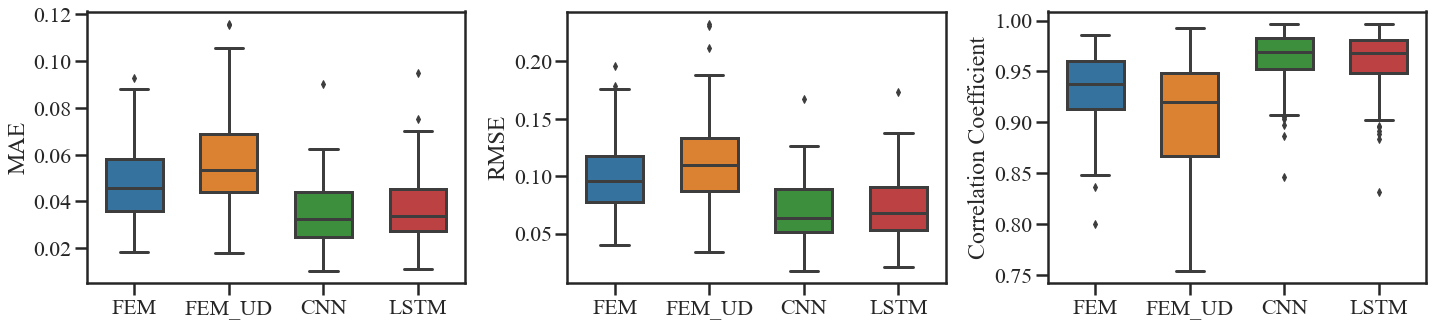

In [26]:
plt.figure(figsize=(24, 5))
plt.subplots_adjust(hspace=0, wspace=0.27)

plt.subplot(1, 3, 1)
ax = sns.boxplot(data=[d for d in MAE_test_rps.T], saturation=0.7, width=0.6)
plt.ylabel('MAE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.subplot(1, 3, 2)
ax = sns.boxplot(data=[d for d in RMSE_test_rps.T], saturation=0.7, width=0.6)
plt.ylabel('RMSE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.subplot(1, 3, 3)
ax = sns.boxplot(data=[d for d in r_test_rps.T], saturation=0.7, width=0.6)
plt.ylabel('Correlation Coefficient')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])

plt.savefig(os.path.join(station + '_results', 'test_boxfig_rps.svg'), bbox_inches='tight')

训练集上的情况

In [ ]:
i = 0
dt = 0.02
pbar = tqdm(range(len(train_idx)), desc='train', ncols=100)
for i in pbar:
    rps_up = matlabeng.getResponseSpectrum(matlab.double(upacc_trainset[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel() / np.max(np.abs(upacc_trainset[i, :]))
    rps_md = matlabeng.getResponseSpectrum(matlab.double(mdacc_trainset[i, :].tolist()), dt)
    rps_md = np.array(rps_md).ravel() / np.max(np.abs(mdacc_trainset[i, :]))
    rps_md_Kal = matlabeng.getResponseSpectrum(matlab.double(mdacc_Kal_trainset[i, :].tolist()), dt)
    rps_md_Kal = np.array(rps_md_Kal).ravel() / np.max(np.abs(mdacc_Kal_trainset[i, :]))
    rps_CNN = matlabeng.getResponseSpectrum(matlab.double(CNNacc_trainset[i, :].tolist()), dt)
    rps_CNN = np.array(rps_CNN).ravel() / np.max(np.abs(CNNacc_trainset[i, :]))
    rps_LSTM = matlabeng.getResponseSpectrum(matlab.double(LSTMacc_trainset[i, :].tolist()), dt)
    rps_LSTM = np.array(rps_LSTM).ravel() / np.max(np.abs(LSTMacc_trainset[i, :]))
    PGA = np.max(np.abs(upacc_trainset[i, :]))
    Sam = np.max(rps_up)


    plt.figure(figsize=(32, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)


    ax1 = plt.subplot2grid((3, 4), (0, 0))
    ax1.plot(ttime, upacc_trainset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, mdacc_trainset[i, :], color=colors[0], linestyle='--', linewidth=1, label='FEM')
    # plt.xlim([15, 25])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)')

    ax2 = plt.subplot2grid((3, 4), (1, 0), rowspan=2)
    ax2.semilogx(Period, rps_up, color='k', linewidth=2, label='Record')
    ax2.semilogx(Period, rps_md, color=colors[0], linestyle='--', linewidth=2, label='FEM')
    plt.xlim([0.01, 20])
    plt.ylim([0, 1.2 * Sam])
    plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

    ax1 = plt.subplot2grid((3, 4), (0, 1))
    ax1.plot(ttime, upacc_trainset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, mdacc_Kal_trainset[i, :], color=colors[1], linestyle='--', linewidth=1, label='FEM_UD')
    # plt.xlim([15, 25])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)')

    ax2 = plt.subplot2grid((3, 4), (1, 1), rowspan=2)
    ax2.semilogx(Period, rps_up, color='k', linewidth=2, label='Record')
    ax2.semilogx(Period, rps_md_Kal, color=colors[1], linestyle='--', linewidth=2, label='FEM_UD')
    plt.xlim([0.01, 20])
    plt.ylim([0, 1.2 * Sam])
    plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

    ax1 = plt.subplot2grid((3, 4), (0, 2))
    ax1.plot(ttime, upacc_trainset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, CNNacc_trainset[i, :], color=colors[2], linestyle='--', linewidth=1, label='DNN-CNN')
    # plt.xlim([15, 25])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)')

    ax2 = plt.subplot2grid((3, 4), (1, 2), rowspan=2)
    ax2.semilogx(Period, rps_up, color='k', linewidth=2, label='Record')
    ax2.semilogx(Period, rps_CNN, color=colors[2], linestyle='--', linewidth=2, label='DNN-CNN')
    plt.xlim([0.01, 20])
    plt.ylim([0, 1.2 * Sam])
    plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

    ax1 = plt.subplot2grid((3, 4), (0, 3))
    ax1.plot(ttime, upacc_trainset[i, :], color='k', linewidth=1, label='Record')
    ax1.plot(ttime, LSTMacc_trainset[i, :], color=colors[3], linestyle='--', linewidth=1, label='DNN-LSTM')
    # plt.xlim([15, 25])
    plt.ylim([-1.05 * PGA, 1.05 * PGA])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)')

    ax2 = plt.subplot2grid((3, 4), (1, 3), rowspan=2)
    ax2.semilogx(Period, rps_up, color='k', linewidth=2, label='Record')
    ax2.semilogx(Period, rps_LSTM, color=colors[3], linestyle='--', linewidth=2, label='DNN-LSTM')
    plt.xlim([0.01, 20])
    plt.ylim([0, 1.2 * Sam])
    plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')

    plt.savefig(os.path.join(station + '_results', 'comparison', 'train%d_%s.svg' % (i, event_list[train_idx[i]])), bbox_inches='tight')
    plt.close()

In [ ]:
MAE_train = np.zeros((len(train_idx), 4))
RMSE_train = np.zeros((len(train_idx), 4))
SMAPE_train = np.zeros((len(train_idx), 4))
r_train = np.zeros((len(train_idx), 4))

MAE_train_rps = np.zeros((len(train_idx), 4))
RMSE_train_rps = np.zeros((len(train_idx), 4))
SMAPE_train_rps = np.zeros((len(train_idx), 4))
r_train_rps = np.zeros((len(train_idx), 4))

pbar = tqdm(range(len(train_idx)), desc='Calculating', ncols=100)
for i in pbar:
    rps_up = matlabeng.getResponseSpectrum(matlab.double(upacc_trainset[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel() / np.max(np.abs(upacc_trainset[i, :]))
    rps_md = matlabeng.getResponseSpectrum(matlab.double(mdacc_trainset[i, :].tolist()), dt)
    rps_md = np.array(rps_md).ravel() / np.max(np.abs(mdacc_trainset[i, :]))
    rps_md_Kal = matlabeng.getResponseSpectrum(matlab.double(mdacc_Kal_trainset[i, :].tolist()), dt)
    rps_md_Kal = np.array(rps_md_Kal).ravel() / np.max(np.abs(mdacc_Kal_trainset[i, :]))
    rps_CNN = matlabeng.getResponseSpectrum(matlab.double(CNNacc_trainset[i, :].tolist()), dt)
    rps_CNN = np.array(rps_CNN).ravel() / np.max(np.abs(CNNacc_trainset[i, :]))
    rps_LSTM = matlabeng.getResponseSpectrum(matlab.double(LSTMacc_trainset[i, :].tolist()), dt)
    rps_LSTM = np.array(rps_LSTM).ravel() / np.max(np.abs(LSTMacc_trainset[i, :]))
    PGA = np.max(np.abs(upacc_trainset[i, :]))
    Sam = np.max(rps_up)
    
    MAE_train[i, 0] = np.mean(np.abs(mdacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)
    MAE_train[i, 1] = np.mean(np.abs(mdacc_Kal_trainset[i, :] - upacc_trainset[i, :]) / PGA)
    MAE_train[i, 2] = np.mean(np.abs(CNNacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)
    MAE_train[i, 3] = np.mean(np.abs(LSTMacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)
    
    RMSE_train[i, 0] = np.sqrt(np.mean(((mdacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)**2))
    RMSE_train[i, 1] = np.sqrt(np.mean(((mdacc_Kal_trainset[i, :] - upacc_trainset[i, :]) / PGA)**2))
    RMSE_train[i, 2] = np.sqrt(np.mean(((CNNacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)**2))
    RMSE_train[i, 3] = np.sqrt(np.mean(((LSTMacc_trainset[i, :] - upacc_trainset[i, :]) / PGA)**2))
    
    r_train[i, 0] = np.corrcoef(mdacc_trainset[i, :], upacc_trainset[i, :])[0, 1]
    r_train[i, 1] = np.corrcoef(mdacc_Kal_trainset[i, :], upacc_trainset[i, :])[0, 1]
    r_train[i, 2] = np.corrcoef(CNNacc_trainset[i, :], upacc_trainset[i, :])[0, 1]
    r_train[i, 3] = np.corrcoef(LSTMacc_trainset[i, :], upacc_trainset[i, :])[0, 1]
    
    MAE_train_rps[i, 0] = np.mean(np.abs(rps_md - rps_up) / Sam)
    MAE_train_rps[i, 1] = np.mean(np.abs(rps_md_Kal - rps_up) / Sam)
    MAE_train_rps[i, 2] = np.mean(np.abs(rps_CNN - rps_up) / Sam)
    MAE_train_rps[i, 3] = np.mean(np.abs(rps_LSTM - rps_up) / Sam)
    
    RMSE_train_rps[i, 0] = np.sqrt(np.mean(((rps_md - rps_up) / Sam)**2))
    RMSE_train_rps[i, 1] = np.sqrt(np.mean(((rps_md_Kal - rps_up) / Sam)**2))
    RMSE_train_rps[i, 2] = np.sqrt(np.mean(((rps_CNN - rps_up) / Sam)**2))
    RMSE_train_rps[i, 3] = np.sqrt(np.mean(((rps_LSTM - rps_up) / Sam)**2))
    
    r_train_rps[i, 0] = np.corrcoef(rps_md, rps_up)[0, 1]
    r_train_rps[i, 1] = np.corrcoef(rps_md_Kal, rps_up)[0, 1]
    r_train_rps[i, 2] = np.corrcoef(rps_CNN, rps_up)[0, 1]
    r_train_rps[i, 3] = np.corrcoef(rps_LSTM, rps_up)[0, 1]

In [ ]:
plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(MAE_train[:, 0], bins=20, binrange=[0, 0.2], color=colors[0], label='FEM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))
plt.subplot(1, 4, 2)
sns.histplot(MAE_train[:, 1], bins=20, binrange=[0, 0.2], color=colors[1], label='FEM_UD')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))
plt.subplot(1, 4, 3)
sns.histplot(MAE_train[:, 2], bins=20, binrange=[0, 0.2], color=colors[2], label='DNN-CNN')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))
plt.subplot(1, 4, 4)
sns.histplot(MAE_train[:, 3], bins=20, binrange=[0, 0.2], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.21, 0.05))
plt.savefig(os.path.join(station + '_results', 'train_MAE.svg'), bbox_inches='tight')


plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(RMSE_train[:, 0], bins=20, binrange=[0, 0.25], color=colors[0], label='FEM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 2)
sns.histplot(RMSE_train[:, 1], bins=20, binrange=[0, 0.25], color=colors[1], label='FEM_UD')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 3)
sns.histplot(RMSE_train[:, 2], bins=20, binrange=[0, 0.25], color=colors[2], label='DNN-CNN')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 4)
sns.histplot(RMSE_train[:, 3], bins=20, binrange=[0, 0.25], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.savefig(os.path.join(station + '_results', 'train_RMSE.svg'), bbox_inches='tight')


plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(r_train[:, 0], bins=20, binrange=[0, 1], color=colors[0], label='FEM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.1, 0.2))
plt.subplot(1, 4, 2)
sns.histplot(r_train[:, 1], bins=20, binrange=[0, 1], color=colors[1], label='FEM_UD')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.1, 0.2))
plt.subplot(1, 4, 3)
sns.histplot(r_train[:, 2], bins=20, binrange=[0, 1], color=colors[2], label='DNN-CNN')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.1, 0.2))
plt.subplot(1, 4, 4)
sns.histplot(r_train[:, 3], bins=20, binrange=[0, 1], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 1.1, 0.2))
plt.savefig(os.path.join(station + '_results', 'train_COrrcoef.svg'), bbox_inches='tight')


plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(MAE_train_rps[:, 0], bins=20, binrange=[0, 0.15], color=colors[0], label='FEM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.16, 0.05))
plt.subplot(1, 4, 2)
sns.histplot(MAE_train_rps[:, 1], bins=20, binrange=[0, 0.15], color=colors[1], label='FEM_UD')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.16, 0.05))
plt.subplot(1, 4, 3)
sns.histplot(MAE_train_rps[:, 2], bins=20, binrange=[0, 0.15], color=colors[2], label='DNN-CNN')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.16, 0.05))
plt.subplot(1, 4, 4)
sns.histplot(MAE_train_rps[:, 3], bins=20, binrange=[0, 0.15], color=colors[3], label='DNN-LSTM')
plt.xlabel('MAE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.16, 0.05))
plt.savefig(os.path.join(station + '_results', 'train_MAE_rps.svg'), bbox_inches='tight')


plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(RMSE_train_rps[:, 0], bins=20, binrange=[0, 0.25], color=colors[0], label='FEM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 2)
sns.histplot(RMSE_train_rps[:, 1], bins=20, binrange=[0, 0.25], color=colors[1], label='FEM_UD')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 3)
sns.histplot(RMSE_train_rps[:, 2], bins=20, binrange=[0, 0.25], color=colors[2], label='DNN-CNN')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.subplot(1, 4, 4)
sns.histplot(RMSE_train_rps[:, 3], bins=20, binrange=[0, 0.25], color=colors[3], label='DNN-LSTM')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0, 0.26, 0.05))
plt.savefig(os.path.join(station + '_results', 'train_RMSE_rps.svg'), bbox_inches='tight')


plt.figure(figsize=(28, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 4, 1)
sns.histplot(r_train_rps[:, 0], bins=20, binrange=[0.7, 1.0], color=colors[0], label='FEM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.7, 1.01, 0.1))
plt.subplot(1, 4, 2)
sns.histplot(r_train_rps[:, 1], bins=20, binrange=[0.7, 1.0], color=colors[1], label='FEM_UD')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.7, 1.01, 0.1))
plt.subplot(1, 4, 3)
sns.histplot(r_train_rps[:, 2], bins=20, binrange=[0.7, 1.0], color=colors[2], label='DNN-CNN')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.7, 1.01, 0.1))
plt.subplot(1, 4, 4)
sns.histplot(r_train_rps[:, 3], bins=20, binrange=[0.7, 1.0], color=colors[3], label='DNN-LSTM')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.xticks(np.arange(0.7, 1.01, 0.1))
plt.savefig(os.path.join(station + '_results', 'train_corrcoef_rps.svg'), bbox_inches='tight')


plt.figure(figsize=(24, 5))
plt.subplots_adjust(hspace=0, wspace=0.27)
plt.subplot(1, 3, 1)
ax = sns.boxplot(data=[d for d in MAE_train.T], saturation=0.7, width=0.6)
plt.ylabel('MAE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.subplot(1, 3, 2)
ax = sns.boxplot(data=[d for d in RMSE_train.T], saturation=0.7, width=0.6)
plt.ylabel('RMSE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.subplot(1, 3, 3)
ax = sns.boxplot(data=[d for d in r_train.T], saturation=0.7, width=0.6)
plt.ylabel('Correlation Coefficient')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.savefig(os.path.join(station + '_results', 'train_boxfig.svg'), bbox_inches='tight')


plt.figure(figsize=(24, 5))
plt.subplots_adjust(hspace=0, wspace=0.27)
plt.subplot(1, 3, 1)
ax = sns.boxplot(data=[d for d in MAE_train_rps.T], saturation=0.7, width=0.6)
plt.ylabel('MAE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.subplot(1, 3, 2)
ax = sns.boxplot(data=[d for d in RMSE_train_rps.T], saturation=0.7, width=0.6)
plt.ylabel('RMSE')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.subplot(1, 3, 3)
ax = sns.boxplot(data=[d for d in r_train_rps.T], saturation=0.7, width=0.6)
plt.ylabel('Correlation Coefficient')
ax.set_xticklabels(['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM'])
plt.savefig(os.path.join(station + '_results', 'train_boxfig_rps.svg'), bbox_inches='tight')

将结果写入表格里

In [ ]:
data_types = ['acc', 'rps']
indicators = ['MAE', 'RMSE', 'r']
models = ['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM']
test_results = [[MAE_test, RMSE_test, r_test], [MAE_test_rps, RMSE_test_rps, r_test_rps]]

test_excel = pd.DataFrame({'Event': list(event_list[test_idx])})
PGA_test = np.max(np.abs(upacc_testset), axis=1)
test_excel['PGA (gal)'] = list(PGA_test)

for i in range(len(data_types)):
    for j in range(len(indicators)):
        for k in range(len(models)):
            test_excel[models[k] + '_' + indicators[j] + '_' + data_types[i]] = list(test_results[i][j][:, k])
test_excel.to_excel(os.path.join(station + '_results', 'test.xlsx'), sheet_name='test')

In [ ]:
data_types = ['acc', 'rps']
indicators = ['MAE', 'RMSE', 'r']
models = ['FEM', 'FEM_UD', 'DNN-CNN', 'DNN-LSTM']
train_results = [[MAE_train, RMSE_train, r_train], [MAE_train_rps, RMSE_train_rps, r_train_rps]]

train_excel = pd.DataFrame({'Event': list(event_list[train_idx])})
PGA_train = np.max(np.abs(upacc_trainset), axis=1)
train_excel['PGA (gal)'] = list(PGA_train)

for i in range(len(data_types)):
    for j in range(len(indicators)):
        for k in range(len(models)):
            train_excel[models[k] + '_' + indicators[j] + '_' + data_types[i]] = list(train_results[i][j][:, k])
train_excel.to_excel(os.path.join(station + '_results', 'train.xlsx'), sheet_name='train')

In [ ]:
PGA_test = np.max(np.abs(upacc_testset), axis=1)
idx_list = [2, 13, 17, 21, 27, 31, 38, 41, 51, 53, 61, 62, 64, 76, 77, 89, 91, 96, ]
selectfile = open(os.path.join(station + '_results', 'selections.out'), 'w')
for idx in idx_list:
    selectfile.write('%d\t%s\t%.1f\n' % (idx, event_list[test_idx[idx]], PGA_test[idx]))
    selectfile.write('Acceleration time history\n')
    for content in MAE_test[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
    for content in RMSE_test[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
    for content in r_test[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
    selectfile.write('Response spectrum\n')
    for content in MAE_test_rps[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
    for content in RMSE_test_rps[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
    for content in r_test_rps[idx, :]:
        selectfile.write('%.3f\t' % content)
    selectfile.write('\n')
selectfile.close()

In [ ]:
np.mean(np.abs(upacc_testset / PGA_test[:, None]))
# np.sqrt(np.mean((np.abs(upacc_testset / PGA_test[:, None]))**2))